In [3]:
import os
import numpy as np
import pandas as pd
from datetime import date

from sklearn.model_selection import KFold, train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import log_loss, roc_auc_score, auc, roc_curve


import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)

DATA_path = r"C:\Users\user\Documents\GitHub\2nd-ML100Days\homework\Day_051_HW.ipynb\ml100marathon-02-01"

import os
import seaborn as sns
from scipy import stats
color = sns.color_palette()
sns.set_style('darkgrid')

In [4]:
dfoff_file = 'dfoff.pkl'
dftest_file = 'dftest.pkl'
def loadData():
    if os.path.isfile(dfoff_file) and os.path.isfile(dfoff_file):
        dfoff = pd.read_pickle(dfoff_file)
        dftest = pd.read_pickle(dftest_file)
    else:
        dfoff = pd.read_csv(os.path.join(DATA_path,'train_offline.csv'))
        dftest = pd.read_csv(os.path.join(DATA_path,'test_offline.csv'))
        dftest = dftest[~dftest.Date_received.isna()]
        dftest.reset_index(drop=True, inplace=True)
        print(dfoff.shape)
        print(dftest.shape)
        dfoff = dfoff.drop_duplicates()
        dfoff.head(3)

        ## Creat target label 
        """
        According to the definition, 
        1) buy with coupon within (include) 15 days ==> 1
        2) buy with coupon but out of 15 days ==> 0
        3) buy without coupon ==> -1 (we don't care)
        """
        def label(row):
            if np.isnan(row['Date_received']):
                return -1
            if not np.isnan(row['Date']):
                td = pd.to_datetime(row['Date'], format='%Y%m%d') -  pd.to_datetime(row['Date_received'], format='%Y%m%d')
                if td <= pd.Timedelta(15, 'D'):
                    return 1
            return 0

        dfoff["label"] = dfoff.apply(label, axis=1)
        dfoff["label"].value_counts()
        # Generate features - weekday acquired coupon
        def getWeekday(row):
            if (np.isnan(row)) or (row==-1):
                return row
            else:
                return pd.to_datetime(row, format = "%Y%m%d").dayofweek+1 # add one to make it from 0~6 -> 1~7

        dfoff['weekday'] = dfoff['Date_received'].apply(getWeekday)
        dftest['weekday'] = dftest['Date_received'].apply(getWeekday)
        # Generate features - coupon discount and distance
        def getDiscountType(row):
            if row == 'null':
                return 'null'
            elif ':' in row:
                return 1
            else:
                return 0

        def convertRate(row):
            """Convert discount to rate"""
            if row == 'null':
                return 1.0
            elif ':' in row:
                rows = row.split(':')
                return 1.0 - float(rows[1])/float(rows[0])
            else:
                return float(row)

        def getDiscountMan(row):
            if ':' in row:
                rows = row.split(':')
                return int(rows[0])
            else:
                return 0

        def getDiscountJian(row):
            if ':' in row:
                rows = row.split(':')
                return int(rows[1])
            else:
                return 0

        def processData(df):

            # convert discunt_rate
            df['discount_rate'] = df['Discount_rate'].astype('str').apply(convertRate)
            df['discount_man'] = df['Discount_rate'].astype('str').apply(getDiscountMan)
            df['discount_jian'] = df['Discount_rate'].astype('str').apply(getDiscountJian)
            df['discount_type'] = df['Discount_rate'].astype('str').apply(getDiscountType)

            return df

        dfoff = processData(dfoff)
        dftest = processData(dftest)

        def split_train_valid(row, date_cut="20160416"):
            if (np.isnan(row)) or (row==-1):
                return False
            else:
                is_train = True if pd.to_datetime(row, format="%Y%m%d") < pd.to_datetime(date_cut, format="%Y%m%d") else False
            return is_train

        dfoff["is_train"] = dfoff["Date_received"].apply(split_train_valid)
        
        dfoff.to_pickle(dfoff_file)
        dftest.to_pickle(dftest_file)
    return dfoff,dftest

In [5]:
dfoff, dftest = loadData()
print(dfoff.shape)
print(dftest.shape)
statistic_cols = []

(1160742, 7)
(306313, 9)
(1124653, 14)
(306313, 14)


In [7]:
dfoff.loc[dfoff.Distance.isna(), "Distance"] = 11 # df.Distance.max()
dftest.loc[dftest.Distance.isna(), "Distance"] = 11 # df.Distance.max()

In [8]:
# u_count Purchase Count Group by  User_id 
df = dfoff[dfoff["label"]!=0]
count_df = df.groupby(['User_id']).size().reset_index(name='u_count')
dfoff = pd.merge(dfoff, count_df, on=['User_id'], how='left')
dftest = pd.merge(dftest, count_df, on=['User_id'], how='left')
print((dftest['u_count'].isnull().sum()/dftest.shape[0]))
statistic_cols.append('u_count')

0.5569988867596217


In [9]:
# u_1count Coupon Purchase Count Group by  User_id 
df = dfoff[dfoff["label"]==1]
count_df = df.groupby(['User_id']).size().reset_index(name='u_1count')
dfoff = pd.merge(dfoff, count_df, on=['User_id'], how='left')
dftest = pd.merge(dftest, count_df, on=['User_id'], how='left')
print((dftest['u_1count'].isnull().sum()/dftest.shape[0]))
statistic_cols.append('u_1count')

0.9190240048577762


In [10]:
# um_count Purchase Count Group by User_id, Merchant_id 
df = dfoff[dfoff["label"]!=0]
count_df = df.groupby(['User_id','Merchant_id']).size().reset_index(name='um_count')
dfoff = pd.merge(dfoff, count_df, on=['User_id','Merchant_id'], how='left')
dftest = pd.merge(dftest, count_df, on=['User_id','Merchant_id'], how='left')
print((dftest['um_count'].isnull().sum()/dftest.shape[0]))
statistic_cols.append('um_count')

0.7421950749723322


In [11]:
# um_count Coupon Purchase Count Group by User_id, Merchant_id 
df = dfoff[dfoff["label"]==1]
count_df = df.groupby(['User_id','Merchant_id']).size().reset_index(name='um_1count')
dfoff = pd.merge(dfoff, count_df, on=['User_id','Merchant_id'], how='left')
dftest = pd.merge(dftest, count_df, on=['User_id','Merchant_id'], how='left')
print((dftest['um_1count'].isnull().sum()/dftest.shape[0]))
statistic_cols.append('um_1count')

0.9641543127454597


In [12]:
# m_count Purchase Count Group by Merchant_id
df = dfoff[dfoff["label"]!=0]
count_df = df.groupby(['Merchant_id']).size().reset_index(name='m_count')
dfoff = pd.merge(dfoff, count_df, on=['Merchant_id'], how='left')
dftest = pd.merge(dftest, count_df, on=['Merchant_id'], how='left')
print((dftest['m_count'].isnull().sum()/dftest.shape[0]))
statistic_cols.append('m_count')

0.023596778458635448


In [13]:
# m_1count Purchase Count Group by Merchant_id
df = dfoff[dfoff["label"]==1]
count_df = df.groupby(['Merchant_id']).size().reset_index(name='m_1count')
dfoff = pd.merge(dfoff, count_df, on=['Merchant_id'], how='left')
dftest = pd.merge(dftest, count_df, on=['Merchant_id'], how='left')
print((dftest['m_1count'].isnull().sum()/dftest.shape[0]))
statistic_cols.append('m_1count')

0.18789930561223323


In [14]:
# c_1count Purchase Count Group by Coupon_id
df = dfoff[dfoff["label"]==1]
count_df = df.groupby(['Coupon_id']).size().reset_index(name='c_1count')
dfoff = pd.merge(dfoff, count_df, on=['Coupon_id'], how='left')
dftest = pd.merge(dftest, count_df, on=['Coupon_id'], how='left')
print((dftest['c_1count'].isnull().sum()/dftest.shape[0]))
statistic_cols.append('c_1count')

0.8637374189146396


In [15]:
# m_distance_mean Purchase Count Group by User_id
df = dfoff[dfoff["label"]!=0]
count_df = df.groupby(['Merchant_id'])['Distance'].mean().reset_index(name='m_distance_mean')
dfoff = pd.merge(dfoff, count_df, on=['Merchant_id'], how='left')
dftest = pd.merge(dftest, count_df, on=['Merchant_id'], how='left')
print((dftest['m_distance_mean'].isnull().sum()/dftest.shape[0]))
statistic_cols.append('m_distance_mean')

0.023596778458635448


In [16]:
# m_distance_max Purchase Count Group by User_id
df = dfoff[dfoff["label"]!=0]
count_df = df.groupby(['Merchant_id'])['Distance'].mean().reset_index(name='m_distance_max')
dfoff = pd.merge(dfoff, count_df, on=['Merchant_id'], how='left')
dftest = pd.merge(dftest, count_df, on=['Merchant_id'], how='left')
print((dftest['m_distance_max'].isnull().sum()/dftest.shape[0]))
statistic_cols.append('m_distance_max')

0.023596778458635448


In [17]:
# m_1distance_mean Purchase Count Group by User_id
df = dfoff[dfoff["label"]==1]
count_df = df.groupby(['Merchant_id'])['Distance'].mean().reset_index(name='m_1distance_mean')
dfoff = pd.merge(dfoff, count_df, on=['Merchant_id'], how='left')
dftest = pd.merge(dftest, count_df, on=['Merchant_id'], how='left')
print((dftest['m_1distance_mean'].isnull().sum()/dftest.shape[0]))
statistic_cols.append('m_1distance_mean')

0.18789930561223323


In [18]:
# m_1distance_max Purchase Count Group by User_id
df = dfoff[dfoff["label"]==1]
count_df = df.groupby(['Merchant_id'])['Distance'].mean().reset_index(name='m_1distance_max')
dfoff = pd.merge(dfoff, count_df, on=['Merchant_id'], how='left')
dftest = pd.merge(dftest, count_df, on=['Merchant_id'], how='left')
print((dftest['m_1distance_max'].isnull().sum()/dftest.shape[0]))
statistic_cols.append('m_1distance_max')

0.18789930561223323


In [19]:
# weekday_type (weekend = 1)
dfoff['weekday_type'] = dfoff['weekday'].apply(lambda x : 1 if x in [6,7] else 0 ) # apply to trainset
dftest['weekday_type'] = dftest['weekday'].apply(lambda x : 1 if x in [6,7] else 0 ) # apply to testset

In [20]:
weekdaycols = ['weekday_' + str(i) for i in range(1,8)]
print(weekdaycols)

tmpdf = pd.get_dummies(dfoff['weekday'].replace(-1, np.nan))
tmpdf.columns = weekdaycols
dfoff[weekdaycols] = tmpdf
dfoff.head(3)

['weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'weekday_7']


,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date,label,weekday,discount_rate,...,m_1distance_mean,m_1distance_max,weekday_type,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7
0,1439408,2632,NaN,NaN,0.0,NaN,20160217.0,-1,NaN,NaN,...,1.0,1.0,0,0,0,0,0,0,0,0
1,1439408,2632,8591.0,20:1,0.0,20160217.0,NaN,0,3.0,0.95,...,1.0,1.0,0,0,0,1,0,0,0,0
2,1439408,2632,1078.0,20:1,0.0,20160319.0,NaN,0,6.0,0.95,...,1.0,1.0,1,0,0,0,0,0,1,0


In [21]:
tmpdf = pd.get_dummies(dftest['weekday'].replace(-1, np.nan))
tmpdf.columns = weekdaycols
dftest[weekdaycols] = tmpdf
dftest.head(3)

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date,label,to_testset,weekday,...,m_1distance_mean,m_1distance_max,weekday_type,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7
0,1439408,4663,11002.0,150:20,1.0,20160528.0,NaN,0,True,6,...,2.285714,2.285714,1,0,0,0,0,0,1,0
1,1439408,2632,8591.0,20:1,0.0,20160613.0,NaN,0,True,1,...,1.000000,1.000000,0,1,0,0,0,0,0,0
2,1439408,2632,8591.0,20:1,0.0,20160516.0,20160613.0,0,True,1,...,1.000000,1.000000,0,1,0,0,0,0,0,0


In [22]:
good_statistic_cols = []
for c in statistic_cols:
    ratio = dftest[c].isnull().sum()/dftest.shape[0]
    print(c,(dfoff[c].isnull().sum()/dfoff.shape[0]),ratio)
    if (ratio<0.75):
        good_statistic_cols.append(c)
    dfoff[c] = dfoff[c].fillna(0)
    dftest[c] = dftest[c].fillna(0)

u_count 0.40736031469262074 0.5569988867596217
u_1count 0.847072830464152 0.9190240048577762
um_count 0.48879521061162867 0.7421950749723322
um_1count 0.892905634004444 0.9641543127454597
m_count 0.00046058650979457664 0.023596778458635448
m_1count 0.06662232706443677 0.18789930561223323
c_1count 0.38453549672654586 0.8637374189146396
m_distance_mean 0.00046058650979457664 0.023596778458635448
m_distance_max 0.00046058650979457664 0.023596778458635448
m_1distance_mean 0.06662232706443677 0.18789930561223323
m_1distance_max 0.06662232706443677 0.18789930561223323


In [23]:
## Naive model
df = dfoff[dfoff['label'] != -1].copy()
train = df[df["is_train"]]
valid = df[~df["is_train"]]
train.reset_index(drop=True, inplace=True)
valid.reset_index(drop=True, inplace=True)
print("Train size: {}, #positive: {}".format(len(train), train["label"].sum()))
print("Valid size: {}, #positive: {}".format(len(valid), valid["label"].sum()))

original_feature = ['discount_rate',
                    'discount_type',
                    'discount_man', 
                    'discount_jian',
                    'Distance', 
                    'weekday_type'] + weekdaycols + good_statistic_cols
print(len(original_feature),original_feature)

Train size: 632003, #positive: 30506
Valid size: 78877, #positive: 3769
21 ['discount_rate', 'discount_type', 'discount_man', 'discount_jian', 'Distance', 'weekday_type', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'weekday_7', 'u_count', 'um_count', 'm_count', 'm_1count', 'm_distance_mean', 'm_distance_max', 'm_1distance_mean', 'm_1distance_max']


In [24]:
predictors = original_feature
train[predictors].head(3)

,discount_rate,discount_type,discount_man,discount_jian,Distance,weekday_type,weekday_1,weekday_2,weekday_3,weekday_4,...,weekday_6,weekday_7,u_count,um_count,m_count,m_1count,m_distance_mean,m_distance_max,m_1distance_mean,m_1distance_max
0,0.95,1,20,1,0.0,0,0,0,1,0,...,0,0,1.0,1.0,14.0,1.0,1.357143,1.357143,1.000000,1.000000
1,0.95,1,20,1,0.0,1,0,0,0,0,...,1,0,1.0,1.0,14.0,1.0,1.357143,1.357143,1.000000,1.000000
2,0.90,1,200,20,1.0,0,0,0,0,0,...,0,0,0.0,0.0,15813.0,1540.0,1.251945,1.251945,2.042208,2.042208


In [25]:
train.isnull().sum().sort_values(ascending=False).head()

Date           595694
weekday_7           0
u_1count            0
Merchant_id         0
Coupon_id           0
dtype: int64

In [26]:
print(train.shape)
print(train[predictors].shape)
print(valid[predictors].shape)
print(train['label'].shape)
print(valid['label'].shape)
train[predictors].head(3)

(632003, 33)
(632003, 21)
(78877, 21)
(632003,)
(78877,)


,discount_rate,discount_type,discount_man,discount_jian,Distance,weekday_type,weekday_1,weekday_2,weekday_3,weekday_4,...,weekday_6,weekday_7,u_count,um_count,m_count,m_1count,m_distance_mean,m_distance_max,m_1distance_mean,m_1distance_max
0,0.95,1,20,1,0.0,0,0,0,1,0,...,0,0,1.0,1.0,14.0,1.0,1.357143,1.357143,1.000000,1.000000
1,0.95,1,20,1,0.0,1,0,0,0,0,...,1,0,1.0,1.0,14.0,1.0,1.357143,1.357143,1.000000,1.000000
2,0.90,1,200,20,1.0,0,0,0,0,0,...,0,0,0.0,0.0,15813.0,1540.0,1.251945,1.251945,2.042208,2.042208


In [29]:
import tensorflow as tf
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import metrics
from tensorflow.keras import losses

# simple early stopping
earlystop = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)


batch_size = 128
epochs = 50
    
model = Sequential()
model.add(Dense(32, input_shape=(21,)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))

model.add(Dense(16))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))

model.add(Dense(1, activation="sigmoid")) 

print(model.summary())
model.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=1e-3),
              metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 32)                704       
_________________________________________________________________
batch_normalization_v1_2 (Ba (None, 32)                128       
_________________________________________________________________
activation_2 (Activation)    (None, 32)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)                528       
_________________________________________________________________
batch_normalization_v1_3 (Ba (None, 16)                64        
_________________________________________________________________
activation_3 (Activation)    (None, 16)                0         
__________

In [30]:
print(train[predictors].shape)
model_history = model.fit(x=train[predictors], y=train['label'],
                          batch_size=batch_size,
                          epochs=epochs, shuffle=True,
                          validation_data=(valid[predictors], valid['label']),
                          callbacks=[earlystop,checkpoint])

(632003, 21)
Train on 632003 samples, validate on 78877 samples
Epoch 1/50
631680/632003 [============================>.] - ETA: 0s - loss: 0.1937 - acc: 0.9358
Epoch 00001: val_loss improved from inf to 0.13767, saving model to best_model.h5
632003/632003 [==============================] - 53s 84us/sample - loss: 0.1936 - acc: 0.9358 - val_loss: 0.1377 - val_acc: 0.9526
Epoch 2/50
631040/632003 [============================>.] - ETA: 0s - loss: 0.1370 - acc: 0.9519
Epoch 00002: val_loss improved from 0.13767 to 0.12973, saving model to best_model.h5
632003/632003 [==============================] - 41s 65us/sample - loss: 0.1370 - acc: 0.9519 - val_loss: 0.1297 - val_acc: 0.9527
Epoch 3/50
631936/632003 [============================>.] - ETA: 0s - loss: 0.1263 - acc: 0.9520
Epoch 00003: val_loss improved from 0.12973 to 0.12813, saving model to best_model.h5
632003/632003 [==============================] - 49s 77us/sample - loss: 0.1264 - acc: 0.9520 - val_loss: 0.1281 - val_acc: 0.953

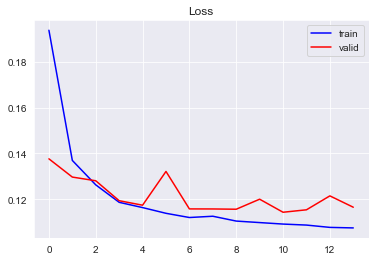

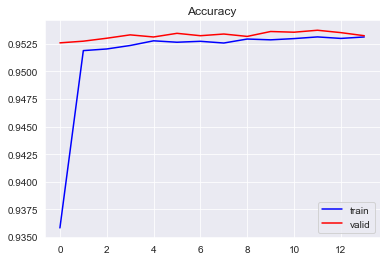

In [31]:
%matplotlib inline
import matplotlib.pyplot as plt  # Matlab-style plotting

train_loss = model_history.history['loss']
train_acc = model_history.history['acc']
valid_loss = model_history.history['val_loss']
valid_acc = model_history.history['val_acc']
plt.plot(train_loss, 'b', label='train')
plt.plot(valid_loss, 'r', label='valid')
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(train_acc, 'b', label='train')
plt.plot(valid_acc, 'r', label='valid')
plt.legend(loc=4)
plt.title("Accuracy")
plt.show()

In [32]:
# load the saved model
from tensorflow.keras.models import load_model
from tensorflow.keras import losses

saved_model = load_model('best_model.h5')

In [33]:
y_valid_pred = saved_model.predict(valid[predictors])

In [34]:
from sklearn.metrics import roc_auc_score, accuracy_score
auc_score = roc_auc_score(y_true=valid.label, y_score=y_valid_pred)
acc = accuracy_score(y_true=valid.label, y_pred=y_valid_pred.argmax(axis=1))
print("Validation AUC: {:.3f}, Accuracy: {:.3f}".format(auc_score, acc))

Validation AUC: 0.940, Accuracy: 0.952


In [35]:
targetset = dftest.copy()
print(targetset.shape)
targetset = targetset[~targetset.Coupon_id.isna()]
targetset.reset_index(drop=True, inplace=True)
testset = targetset.copy()

y_test_pred = saved_model.predict(testset[predictors])

(306313, 33)


In [36]:
y_test_pred

array([[0.00012702],
       [0.04565391],
       [0.04565391],
       ...,
       [0.00160179],
       [0.00011364],
       [0.00019381]], dtype=float32)

In [37]:
output = pd.concat((targetset[["User_id", "Coupon_id", "Date_received"]], pd.DataFrame(y_test_pred[:])), axis=1)
output.columns = ["User_id", "Coupon_id", "Date_received","pred_prob"]
print(output.shape)
output.head(3)

(306313, 4)


,User_id,Coupon_id,Date_received,pred_prob
0,1439408,11002.0,20160528.0,0.000127
1,1439408,8591.0,20160613.0,0.045654
2,1439408,8591.0,20160516.0,0.045654


In [38]:
output.loc[:, "User_id"] = output["User_id"].apply(lambda x:str(int(x)))
output.loc[:, "Coupon_id"] = output["Coupon_id"].apply(lambda x:str(int(x)))
output.loc[:, "Date_received"] = output["Date_received"].apply(lambda x:str(int(x)))
output["uid"] = output[["User_id", "Coupon_id", "Date_received"]].apply(lambda x: '_'.join(x.values), axis=1)
output.reset_index(drop=True, inplace=True)

In [39]:
### NOTE: YOUR SUBMITION FILE SHOULD HAVE COLUMN NAME: uid, label
out = output.groupby("uid", as_index=False).mean()
out = out[["uid", "pred_prob"]]
out.columns = ["uid", "label"]
out.to_csv("0nn-midterm-exam.csv", header=["uid", "label"], index=False) # submission format
out.head()

,uid,label
0,1000020_2705_20160519,0.000217
1,1000020_8192_20160513,0.000245
2,1000065_1455_20160527,0.250389
3,1000085_8067_20160513,0.000109
4,1000086_2418_20160613,0.000415
